In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Isentropic Vortex 

In this example we are going to solve the Euler equations for an isentropic two-dimensional vortex in a full-periodic square domain. Since the problem is not diffusive, the expected behavior is for the vortex to be convected unchanged forever. This is a useful example for testing the diffusive properties of our methods, as well as its numerical stability.

$$
    \begin{array}{c}
        \rho_t + \nabla \cdot (\rho u) = 0 \\
        (\rho \mathbf{u})_t + (\mathbf{u} \cdot \nabla)(\rho \mathbf{u}) + \nabla p = 0 \\
        (\rho e)_t + \nabla \cdot(\mathbf{u} (  \rho e + p )) = 0
    \end{array}
$$

The inputs to the network will be the independent variables $x$, $y$ and $t$ and the outputs will be the conserved variables $\rho$, $\rho \mathbf{u}$ and $\rho e$ where $\rho$ is the density, $\mathbf{u} = (u, v)$ is the velocity and $e$ is the specific energy.

![](http://hypar.github.io/Solution_2DNavStokLowMachVortexPETSc.gif)

In [2]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import nangs
from nangs import *
import math 

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.05', '1.10.0')

In [3]:
GAMMA = 1.4

class Euler2d(PDE):
    def computePDELoss(self, inputs, outputs):
        
        r, u, v, p = outputs[:, 0], outputs[:, 1], outputs[:, 2], outputs[:, 3]
        
        # compute derivatives
        grads = self.computeGrads(r, inputs)        
        drdt = grads[:, 2]
        
        grads = self.computeGrads(r*u, inputs)       
        drudx, drudt = grads[:, 0], grads[:, 2]
        
        grads = self.computeGrads(r*v, inputs)          
        drvdy, drvdt = grads[:, 1], grads[:, 2]
        
        grads = self.computeGrads(r*u*u + p, inputs)            
        druupdx = grads[:, 0]

        grads = self.computeGrads(r*u*v, inputs)              
        drvudx, druvdy = grads[:, 0], grads[:, 1]
        
        grads = self.computeGrads(r*v*v + p, inputs)            
        drvvpdy = grads[:, 1]
        
        re = p/(GAMMA-1) + 0.5*r*(u*u + v*v)
        grads = self.computeGrads(re, inputs)    
        dredt = grads[:, 2]
        
        grads = self.computeGrads((re+p)*u, inputs)   
        drepudx = grads[:, 0]
        
        grads = self.computeGrads((re+p)*v, inputs)   
        drepvdy = grads[:, 1]
        
        # compute losses
        return {
            'mass': drdt + drudx + drvdy,
            'mom_x': drudt + druupdx + druvdy,
            'mom_y': drvdt + drvudx + drvvpdy,
            'energy': dredt + drepudx + drepvdy
        }

# instanciate pde
pde = Euler2d(inputs=('x', 'y', 't'), outputs=('r', 'u', 'v', 'p'))

In [4]:
# define the sampler

from nangs import RandomSampler

sampler = RandomSampler({
    'x': [-5., 5.], 
    'y': [-5., 5.],
    't': [0., 10.]
}, device=device, n_samples=1000)

pde.set_sampler(sampler)

In [5]:
from nangs import Dirichlet, Periodic

n_samples = 1000
periodic_x = Periodic(
    RandomSampler({'y': [-5, 5], 't': [0., 10.]}, device=device, n_samples=n_samples), 
    RandomSampler({'x': -5.}, device=device, n_samples=n_samples), 
    RandomSampler({'x': 5.}, device=device, n_samples=n_samples), 
    name="periodic-x"
)

periodic_y = Periodic(
    RandomSampler({'x': [-5, 5], 't': [0., 10.]}, device=device, n_samples=n_samples), 
    RandomSampler({'y': -5.}, device=device, n_samples=n_samples), 
    RandomSampler({'y': 5.}, device=device, n_samples=n_samples), 
    name="periodic-y"
)

pde.add_boco(periodic_x)
pde.add_boco(periodic_y)

/home/juan/miniconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


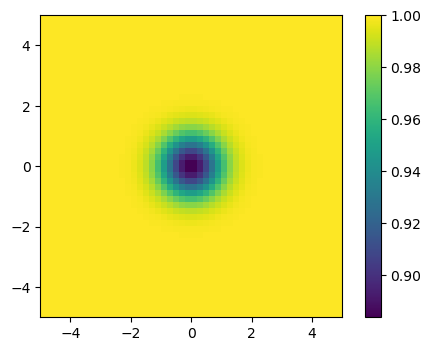

In [6]:
# condición inicial

b = 5

x = torch.linspace(-5,5,50)
y = torch.linspace(-5,5,50)
xx, yy = torch.meshgrid(x,y)

def compute_initial_condition(inputs):
    x, y = inputs['x'], inputs['y']
    r2 = x**2 + y**2
    r0 = (1-(b*(GAMMA-1))/(8*math.pi*math.pi*GAMMA)*torch.exp(1-r2))**(1/(GAMMA-1))
    u0 = 1 - b/(2*math.pi)*torch.exp(0.5*(1-r2))*y
    v0 = b/(2*math.pi)*torch.exp(0.5*(1-r2))*x
    p0 = r0**GAMMA
    return {
        'r': r0,
        'u': u0,
        'v': v0,
        'p': p0
    }

ic = compute_initial_condition({'x': xx, 'y': yy})
r0, u0, v0, p0 = ic['r'], ic['u'], ic['v'], ic['p']

plt.figure(dpi=100)
plt.imshow(r0, vmin=r0.min(), vmax=r0.max(), origin='lower', extent=[-5, 5, -5 ,5])
plt.colorbar()
plt.show()

In [7]:
# no se si esto está bien

initial = Dirichlet(
    RandomSampler({'x': [-5, 5], 'y': [-5., 5.], 't': 0.}, device=device, n_samples=n_samples), 
    compute_initial_condition,
    name="initial"
)

pde.add_boco(initial)

In [8]:
# solve

from nangs import MLP

LR = 1e-3
N_STEPS = 10000
NUM_LAYERS = 3
NUM_HIDDEN = 100

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

{'mass': 4e-05, 'mom_x': 9e-05, 'mom_y': 0.00013, 'energy': 3e-05, 'periodic-x': 1e-05, 'periodic-y': 0.0, 

CPU times: user 2min 16s, sys: 1.29 s, total: 2min 17s
Wall time: 2min 16s


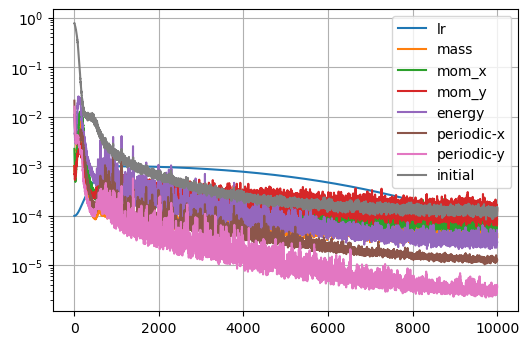

In [18]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)
plt.show()
plt.close()

In [14]:
# evaluate the solution

x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
t = np.linspace(0,10,40)
grid = np.stack(np.meshgrid(x, y, t), -1).reshape(-1, 3)
X = torch.from_numpy(grid).float().to(device)
outputs = pde.eval(X).cpu()
ro = outputs[:, 0].view(len(x),len(y),len(t)).numpy()

_x, _y = np.meshgrid(x, y)
r2 = _x*_x + _y*_y
r00 = (1-(b*(GAMMA-1))/(8*np.pi*np.pi*GAMMA)*np.exp(1-r2))**(1/(GAMMA-1))

In [19]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update_plot(i, t, ro):
    ax1.clear()
    ax1.imshow(ro[...,i].reshape((len(y),len(x))))
    ax1.set_xlabel("x", fontsize=14)
    ax1.set_ylabel("y", fontsize=14, rotation=np.pi/2)
    ax1.set_title(f"t = {t[i]:.2f}", fontsize=14)
    ax2.clear()
    ax2.plot(x, r00[:,len(r00)//2], label="initial")
    ax2.plot(x, ro[...,i][len(ro[...,i])//2,:], label="numeric")
    ax2.legend(loc='upper right')
    ax2.set_xlabel('x')
    ax2.set_ylabel('r')
    ax2.grid(True)
    return ax1, ax2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
im = ax1.imshow(ro[...,0].reshape((len(y),len(x))))
fig.colorbar(im, ax=ax1)
anim = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(t, ro), interval=100)
plt.close()

In [20]:
anim